# `Практикум по программированию на языке Python`

## `Задание 03. Рекуррентные Нейронные Сети. Dropout. LM`

#### Фамилия, имя: 

Дата выдачи: <span style="color:red">__30 марта 23:59__</span>.

Мягкий дедлайн: <span style="color:red">__13 апреля 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __7 баллов__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2024`

Данное задание будет состоять из двух частей:
1. Применение рекуррентной сети для решения задачи классификации текста. Более конкретно -- предсказания рейтинга отзыва фильма.
2. Простейшая лингвистическая модель для генерации текста на основе LSTM.

При выполнении задания вы обучите LSTM с разным уровнем "коробочности", а также познакомитесь с различными способами применения DropOut к рекуррентным архитектурам. В рекуррентных архитектурах вариантов, куда можно наложить бинарную маску шума, гораздо больше, чем в нейросетях прямого прохода.

Во второй части вы попробуете реализовать простейший рекуррентный декодер для генерации текстов.

Задание сделано так, чтобы его можно было выполнять на CPU, однако RNN - это ресурсоёмкая вещь, поэтому на GPU с ними работать приятнее. Можете попробовать использовать [https://colab.research.google.com](https://colab.research.google.com) - бесплатное облако с GPU.

**Для корректного отображения картинок, вам может понадобится сделать ноутбук доверенным (Trusted) в правом верхнем углу**

# `Часть 0. Загрузка и предобработка данных (1 балл)`

## `Рекомендуемые гиперпараметры`

In [1]:
max_length = 200
top_n_words = 5000

hidden_dim = 128
embedding_dim = 32

num_epochs = 15
batch_size = 64
learning_rate = 1e-3

Первое, что нужно сделать — скачать, предобработать данные и организовать их таким образом, чтобы их можно было подавать в нейронную сеть.

Для обеих частей задания мы будем использовать [**Large Movie Review Dataset**](https://ai.stanford.edu/~amaas/data/sentiment/).

## `Загрузка и предобработка данных`

Загрузите данные по ссылке выше. (**tip**: используйте `wget`)

In [8]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz


--2024-04-06 17:02:14--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80,23M  7,82MB/s    in 12s     

2024-04-06 17:02:27 (6,56 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



Распакуйте скачанные данные в папку `aclImdb` (**tip:** используйте `tar`)

In [9]:
!tar -xf ./aclImdb_v1.tar.gz 

Посмотрите в файле `./aclImdb/README` как организованы данные:

In [10]:
! cat ./aclImdb/train/pos/10003_8.txt

This is not the typical Mel Brooks film. It was much less slapstick than most of his movies and actually had a plot that was followable. Leslie Ann Warren made the movie, she is such a fantastic, under-rated actress. There were some moments that could have been fleshed out a bit more, and some scenes that could probably have been cut to make the room to do so, but all in all, this is worth the price to rent and see it. The acting was good overall, Brooks himself did a good job without his characteristic speaking to directly to the audience. Again, Warren was the best actor in the movie, but "Fume" and "Sailor" both played their parts well.

In [2]:
test_data_path = './aclImdb/test/'
train_data_path = './aclImdb/train/'

In [3]:
import os
from functools import partial
from collections import defaultdict
from tqdm import tqdm

import dill

from IPython.display import Markdown, display
from matplotlib import pyplot as plt

import nltk
from num2words import num2words
nltk.download('stopwords')

import regex as re
import numpy as np

import seaborn as sns

import torch
import torchtext
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark = True
torch.use_deterministic_algorithms(False)

torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.autograd.set_detect_anomaly(False)

torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/artemon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Стандартной предобработкой данных является токенизация текстов. Полученные токены можно будет закодировать и затем подавать на вход нейронной сети. Ключевым моментом, который влияет на скорость работы нейросети и её размер в памяти — размер словаря, используемого при токенизации. Для задачи классификации мы можем убрать часть слов (стоп слова, редкие слова), ускорив обучение без потери в качестве.

In [4]:
STOPWORDS = nltk.corpus.stopwords.words('english')

Реализуйте функцию для токенизации текста. Выполнять токенизацию можно по-разному, но в данном задании предлагается это делать следующим образом:
1. Привести текст к нижнему регистру
2. Убрать html разметку из текстов (`<br />`, ...)
3. Убрать все символы кроме латинских букв
4. Разбить строку по пробелам
5. Убрать стоп слова

In [5]:
def tokenize(text: str):
    """
    :param str text: Input text 
    :return List[str]: List of words
    """
    # к нижнему регистру
    text = text.lower()
    
    # убрать все xml теги
    text = re.sub(r'<[^<]+?>', '', text)
    
    # переводим числа в слова
    text = re.sub(r'(\d+)', lambda m: num2words(m.group()), text)

    # оставляем только латинские буквы
    text = re.sub(r'[^a-zA-Z ]+', '', text)
    text = re.sub(r'  ', ' ', text).strip()
    
    # разбиваем строку по пробелам
    text = text.split(' ')
    
    # удаляем стоп слова
    text = [word for word in text if word not in STOPWORDS]

    return text

In [6]:
tokenize('1. Hello <br /> words!! <br />')

['one', 'hello', 'words']

Теперь мы можем создать словарь, с помощью которого мы будем численно кодировать токены из текста и наоборот.

Удобной обёрткой для создания словарей является класс `torchtext.vocab.Vocab` и фабрика для создания таких классов `torchtext.vocab.vocab`.

In [7]:
torchtext.vocab.vocab??

Signature:
torchtext.vocab.vocab(
    ordered_dict: Dict,
    min_freq: int = 1,
    specials: Optional[List[str]] = None,
    special_first: bool = True,
) -> torchtext.vocab.vocab.Vocab
Source:   
def vocab(
    ordered_dict: Dict, min_freq: int = 1, specials: Optional[List[str]] = None, special_first: bool = True
) -> Vocab:
    r"""Factory method for creating a vocab object which maps tokens to indices.

    Note that the ordering in which key value pairs were inserted in the `ordered_dict` will be respected when building the vocab.
    Therefore if sorting by token frequency is important to the user, the `ordered_dict` should be created in a way to reflect this.

    Args:
        ordered_dict: Ordered Dictionary mapping tokens to their corresponding occurance frequencies.
        min_freq: The minimum frequency needed to include a token in the vocabulary.
        specials: Special symbols to add. The order of supplied tokens will be preserved.
        special_first: Indicates whe

Чтобы создать такой словарь, сначала нужно создать словарь со всеми токенами в тексте и их частотами встречаемости:

In [8]:
counter = defaultdict(int)

for path in ['./aclImdb/test/neg', './aclImdb/test/pos', './aclImdb/train/neg', './aclImdb/train/pos']:
    for file_path in os.listdir(path):
        text = open(os.path.join(path, file_path), 'r', encoding='utf-8', errors='ignore').read().strip()
        for token in tokenize(text):
            counter[token] += 1

Для работы с текстами нам необходимо зарезервировать два специальных токена:
1. `<pad>` для токена означающего паддинг
2. `<unk>` для токенов, которые отсутствуют в словаре

In [9]:
specials = ['<pad>', '<unk>']
for special in specials:
    counter[special] = 0

In [10]:
with open('./counter.dll', 'wb') as f:
    dill.dump(counter, f)

Сохраним данный словарь

Создайте словарь из словаря частот `counter`. Наименьшие *id* отдайте под специальные токены. 

Отбросьте низкочастотные слова, оставив только `top_n_words` слов. Можете использовать любой способ реализации этого условия, например:
1. Оставить в словаре `counter` нужное число слов
2. Подобрать параметр `min_freq`, чтобы оставшееся число слов было близко к необходимому порогу

In [11]:
torchtext.__version__

'0.17.2'

In [12]:
arr = np.array([freq for freq in counter.values()])
print(f'mean: {arr.mean()}, min: {arr.min()}, 70% quant: {np.quantile(arr, 0.7)}')

mean: 27.431118226221198, min: 0, 70% quant: 2.0


In [13]:
vocab = torchtext.vocab.vocab(counter, 20, specials=specials, special_first=True)

In [14]:
vocab.set_default_index(1)

In [15]:
len(vocab), len(counter)

(19716, 220499)

In [16]:
vocab.lookup_indices(['<pad>', '<unk>'])

[0, 1]

In [17]:
vocab.lookup_indices(['this', 'film', 'was', 'awful'])

[1, 33, 1, 1369]

In [27]:
# with open('./vocab.dll', 'wb') as f:
#     dill.dump(vocab, f)

In [2]:
with open('./vocab.dll', 'rb') as f:
    vocab = dill.load(f)

Теперь мы готовы создать обёртку-датасет для наших данных. 

Необходимо добавить несколько опции, которые понадобятся во второй части задания:
1. Ограничение на максимальную длину текста в токенах. Если текст оказывается длиннее, то последние токены отбрасываются
2. Возможность добавить в специальные токены `<sos>`, `<eos>` в начало и конец токенизированного текста
    
**tips:**
1. Обратите особое внимание, что у длинных текстов не должен обрезаться паддинг
2. В исходных данных рейтинг закодирован в названии файла в виде числа от $1$ до $10$. Для удобства, вычтите $1$, чтобы рейтинг был от $0$ до $9$

In [27]:
class LargeMovieReviewDataset(Dataset):
    def __init__(self, data_path, vocab, max_len, pad_sos=False, pad_eos=False):
        """
        :param str data_path: Path to folder with one of the data splits (train or test)
        :param torchtext.vocab.Vocab vocab: dictionary with lookup_indices method
        :param int max_len: Maximum length of tokenized text
        :param bool pad_sos: If True pad sequence at the beginning with <sos> 
        :param bool pad_eos: If True pad sequence at the end with <eos>         
        """
        super().__init__()
        
        self.pad_sos = pad_sos
        if self.pad_sos:
            self.sos_id = vocab.lookup_indices(['<sos>'])[0]
        self.pad_eos = pad_eos
        if self.pad_eos:
            self.eos_id = vocab.lookup_indices(['<eos>'])[0]
        
        self.vocab = vocab
        self.max_len = max_len
        self.data_path = data_path
        self.negative_path = os.path.join(data_path, 'neg')
        self.positive_path = os.path.join(data_path, 'pos')
        
        self.negative_paths = []
        self.positive_paths = []

        for file_path in os.listdir(self.negative_path):
            self.negative_paths.append(os.path.join(self.negative_path, file_path))

        for file_path in os.listdir(self.positive_path):
            self.positive_paths.append(os.path.join(self.positive_path, file_path))
        
        self.filenames = []
        self.texts = []
        self.tokens = []
        self.ratings = []
        self.labels = [0] * len(self.negative_paths) + [1] * len(self.positive_paths)
        
        # Read each file in data_path, tokenize it, get tokens ids, its rating and store
        for path in self.negative_paths + self.positive_paths:
            with open(path, 'r') as file:
                # saving text
                text = file.read().strip()
                self.texts.append(text)
                self.filenames.append(path)
                # saving rating
                self.ratings.append(torch.tensor(int(re.search(r'\d*.txt', path).group()[:-4]) - 1))
                # saving tokens
                tokens = vocab.lookup_indices(tokenize(text))
                if self.pad_sos:
                    tokens = [self.sos_id] + tokens
                if self.pad_eos:
                    tokens = tokens[:self.max_len-1] + [self.eos_id]
                self.tokens.append(torch.tensor(tokens))

        
    def __getitem__(self, idx):
        """
        :param int idx: index of object in dataset
        :return dict: Dictionary with all useful object data 
            {
                'text' str: unprocessed text,
                'label' torch.Tensor(dtype=torch.long): sentiment of the text (0 for negative, 1 for positive)
                'rating' torch.Tensor(dtype=torch.long): rating of the text
                'tokens' torch.Tensor(dtype=torch.long): tensor of tokens ids for the text
                'tokens_len' torch.Tensor(dtype=torch.long): number of tokens
            }
        """
        return {
            'path': self.filenames[idx],
            'text': self.texts[idx],
            'label': self.labels[idx],
            'rating': self.ratings[idx],
            'tokens': self.tokens[idx],
            'tokens_len': torch.tensor(len(self.tokens[idx]))
        }
    
    def __len__(self):
        """
        :return int: number of objects in dataset 
        """
        return len(self.texts)

Создайте датасеты для тестовой и обучающей выборки. 

Обратите внимание, что для задачи классификации нам не потребуется паддинг с помощью `<sos>`, `<eos>`. 

Не забудьте обрезать длинные тексты, передав параметр `max_length`.

In [28]:
# making vocabularies
test_dataset = LargeMovieReviewDataset(test_data_path, vocab, max_length)
train_dataset = LargeMovieReviewDataset(train_data_path, vocab, max_length)

In [33]:
# with open('./test_dataset.dll', 'wb') as f:
#     dill.dump(test_dataset, f)
# with open('./train_dataset.dll', 'wb') as f:
#     dill.dump(train_dataset, f)

In [6]:
with open('./test_dataset.dll', 'rb') as f:
    test_dataset = dill.load(f)
with open('./train_dataset.dll', 'rb') as f:
    train_dataset = dill.load(f)

Посмотрим, как выглядит объект в датасете:

In [18]:
test_dataset[0]

{'path': './aclImdb/test/neg/1821_4.txt',
 'text': "Alan Rickman & Emma Thompson give good performances with southern/New Orleans accents in this detective flick. It's worth seeing for their scenes- and Rickman's scene with Hal Holbrook. These three actors mannage to entertain us no matter what the movie, it seems. The plot for the movie shows potential, but one gets the impression in watching the film that it was not pulled off as well as it could have been. The fact that it is cluttered by a rather uninteresting subplot and mostly uninteresting kidnappers really muddles things. The movie is worth a view- if for nothing more than entertaining performances by Rickman, Thompson, and Holbrook.",
 'label': 0,
 'rating': tensor(3),
 'tokens': tensor([ 2,  3,  4,  5,  6,  7,  8,  1,  9, 10, 11, 12, 13, 14, 15,  1, 16, 17,
         18, 19, 20,  1, 21, 22, 23, 24, 25, 26, 24, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 40, 43, 44,  1, 45, 24, 13, 46, 47,
         

In [19]:
train_dataset[0]

{'path': './aclImdb/train/neg/1821_4.txt',
 'text': "Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audience.<br /><br />Branagh steals the film from under Fishburne's nose, and there's a talented cast on good form.",
 'label': 0,
 'rating': tensor(3),
 'tokens': tensor([ 1452,    29,   661,  5058,  7376,    33,  1018, 13059,  5399,  2887,
           432,  4193, 15299,     1,  7833,    33,     1,  4506,  1144,  1861,
           934,     7,   799]),
 'tokens_len': tensor(23)}

Теперь нам нужно создать `DataLoader` для наших данных. `DataLoader` умеет из коробки объединять список объектов из датасета в один батч, даже когда датасет возвращает словарь тензоров. Однако, это работает только в случае когда все эти тензоры имеют один и тот же размер во всех батчах. В нашем случае, это не так, так как разные тексты могут иметь разную длину.

Чтобы обойти эту проблему у `DataLoader` есть параметр `collate_fn`, который позволяет задать функцию для объединения списка объектов в один батч.

Чтобы объединить несколько тензоров разной длины в один можно использовать функцию `torch.nn.utils.rnn.pad_sequence`

Обратите внимание на её аргументы:
1. `batch_first` определяет по какой оси "складывать" тензоры. Предпочтительнее использовать `batch_first=False` так как это может упростить выполнение задания в дальнейшем 
2. `padding_value` — число, которое будет использоваться в качестве паддинга, чтобы сделать все тензоры одинаковой длины

In [37]:
torch.nn.utils.rnn.pad_sequence([
    torch.tensor([1, 2, 3]),
    torch.tensor([4, 5]),
    torch.tensor([6, 7, 8, 9])
], batch_first=False, padding_value=-1)

tensor([[ 1,  4,  6],
        [ 2,  5,  7],
        [ 3, -1,  8],
        [-1, -1,  9]])

In [29]:
def collate_fn(batch, padding_value, batch_first=False):
    """
    :param List[Dict] batch: List of objects from dataset
    :param int padding_value: Value that will be used to pad tokens
    :param bool batch_first: If True resulting tensor with tokens must have shape [B, T] otherwise [T, B]
    :return dict: Dictionary with all data collated
        {
            'ratings' torch.Tensor(dtype=torch.long): rating of the text for each object in batch
            'labels' torch.Tensor(dtype=torch.long): sentiment of the text for each object in batch
            
            'texts' List[str]: All texts in one list
            'tokens' torch.Tensor(dtype=torch.long): tensor of tokens ids padded with @padding_value
            'tokens_lens' torch.Tensor(dtype=torch.long): number of tokens for each object in batch
        }
    """
    ratings = []
    labels = []
    texts = []
    tokens = []
    tokens_lens = []

    for b in batch:
        ratings.append(b['rating'])
        labels.append(b['label'])
        texts.append(b['text'])
        tokens.append(b['tokens'])
        tokens_lens.append(b['tokens_len'])

    tokens = torch.nn.utils.rnn.pad_sequence(
        tokens, batch_first=batch_first, padding_value=padding_value)
    
    return {
        'ratings': torch.tensor(ratings, dtype=torch.long),
        'labels': torch.tensor(labels, dtype=torch.long),
        'texts': texts,
        'tokens': tokens,
        'tokens_lens': torch.tensor(tokens_lens, dtype=torch.long)
    }

Создайте даталоадеры с использованием `collate_fn`.

**tips**:
1. Передать в `collate_fn` правильное значение паддинга можно, например, с помощью `functools.partial`
2. Если вы работаете в Google Colab, то, возможно, вам будет необходимо установить `num_workers=0` во избежание падения ноутбука.

In [30]:
from functools import partial

padder = vocab.lookup_indices(['<pad>'])[0]
test_dataloader = DataLoader(test_dataset, batch_size * 5, False, num_workers=0, collate_fn=partial(collate_fn, padding_value=padder))
train_dataloader = DataLoader(train_dataset, batch_size, True, num_workers=0, collate_fn=partial(collate_fn, padding_value=padder))

In [40]:
# with open('./test_dataloader.dll', 'wb') as f:
#     dill.dump(test_dataloader, f)
# with open('./train_dataloader.dll', 'wb') as f:
#     dill.dump(train_dataloader, f)

In [7]:
with open('./test_dataloader.dll', 'rb') as f:
    test_dataloader = dill.load(f)
with open('./train_dataloader.dll', 'rb') as f:
    train_dataloader = dill.load(f)

Посмотрим на какой-нибудь батч:

In [31]:
batch = next(iter(test_dataloader))
batch.keys(), batch['labels'], batch['ratings'], batch['tokens'], batch['tokens_lens']

(dict_keys(['ratings', 'labels', 'texts', 'tokens', 'tokens_lens']),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [33]:
batch = next(iter(train_dataloader))
batch.keys(), batch['labels'], batch['ratings'], batch['tokens'], batch['tokens_lens']

(dict_keys(['ratings', 'labels', 'texts', 'tokens', 'tokens_lens']),
 tensor([1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
         0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
         1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]),
 tensor([9, 1, 7, 0, 9, 8, 0, 2, 9, 0, 3, 1, 9, 9, 8, 7, 1, 9, 7, 0, 3, 2, 0, 9,
         0, 9, 0, 9, 3, 7, 9, 0, 9, 8, 9, 3, 3, 7, 6, 3, 9, 8, 8, 1, 9, 9, 9, 1,
         7, 0, 1, 0, 6, 3, 0, 9, 0, 8, 2, 9, 2, 3, 0, 3]),
 tensor([[  402,  1039, 12858,  ...,  5362,  5653,   173],
         [ 1041,  1681,     1,  ..., 15451,  2238,   899],
         [  676,   702,     1,  ...,  1158, 16397,  1016],
         ...,
         [    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0]]),
 tensor([134, 158, 216,  28,  63, 444,  64, 231,  85,  74, 171, 126,  74, 156,
         139,  67,  63, 225, 103,  67, 1

# `Часть 1. Классификация текстов (4 балла)`

## `Сборка и обучение RNN в pytorch (1 балл)`

Создадим переменные для device-agnostic кода:

In [5]:
dtype, device, cuda_device_id = torch.float32, None, 0
os.environ["CUDA_VISIBLE_DEVICES"] = '{0}'.format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = 'cuda:{0:d}'.format(0)
elif torch.backends.mps.is_available():
    device = torch.device('mps:0')
else:
    device = torch.device('cpu')
print(f'Using device: {device}, dtype: {dtype}')

Using device: mps:0, dtype: torch.float32


Наша нейросеть будет обрабатывать входную последовательность по словам (word level). Мы будем использовать простую и стандартную рекуррентную архитектуру для классификации:
1. Слой представлений, превращающий id токена в вектор-эмбеддинг этого слова
2. Слой LSTM
3. Полносвязный слой, предсказывающий выход по последнему скрытому состоянию

Ниже дан код для сборки и обучения нашей нейросети.

Допишите класс-обёртку над LSTM для задачи классификации. 
**Не используйте циклы.**

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [6]:
class RNNClassifier(torch.nn.Module):
    def __init__(
        self, embedding_dim, hidden_dim, output_size, vocab,
        rec_layer=torch.nn.LSTM, num_classes=10, num_layers=1, dropout=None, **kwargs
    ):
        super().__init__()

        self.dropout = dropout
        
        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        
        # Create a simple lookup table that stores embeddings of a fixed dictionary and size.
        #    Use torch.nn.Embedding. Do not forget specify padding_idx!
        padding = self.vocab.lookup_indices(['<pad>'])[0]
        self.word_embeddings = torch.nn.Embedding(num_embeddings=len(self.vocab), embedding_dim=embedding_dim, padding_idx=padding)
        
        if dropout is not None:
            self.rnn = rec_layer(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, dropout=dropout)
        else:
            self.rnn = rec_layer(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers)
        
        # Create linear layer for classification
        self.output = torch.nn.Linear(hidden_dim, num_classes)
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.Tensor(dtype=torch.long) tokens: Batch of texts represented with tokens.
        :param torch.Tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch.
        :return torch.Tensor(dtype=torch.long): Vector representation for each sequence in batch
        """
        # Evaluate embeddings
        embeds = self.word_embeddings(tokens)

        # Make forward pass through recurrent network
        outputs, (hidden, cell_state) = self.rnn(embeds)

        finals = outputs[tokens_lens, np.arange(len(tokens_lens)), :]

        # Pass output from rnn to linear layer 
        # Note: each object in batch has its own length 
        #     so we must take rnn hidden state after the last token for each text in batch
        return self.output(finals)

[Исходный код LSTM](http://pytorch.org/docs/master/_modules/torch/nn/modules/rnn.html#LSTM)

Допишите функции для обучения и оценки модели:

**tip:**
1. В функции `evaluate` при подсчёте метрик учитывайте, что батчи могут иметь разный размер. (в частности последний батч)

In [7]:
import wandb

In [13]:
def train_epoch(dataloader, model, loss_fn, optimizer, device, step, chunk) -> int:
    model.train()
    for idx, data in enumerate(dataloader):
        optimizer.zero_grad()
        # 1. Take data from batch
        d, lenghts, ground  = data['tokens'].to(device), data['tokens_lens'], data['ratings'].to(device)
        # 2. Perform forward pass
        preds = model(d, lenghts)
        # 3. Evaluate loss
        loss = loss_fn(preds, ground)
        # 4. Make optimizer step
        loss.backward()
        optimizer.step()

        step += 1
        if step % chunk == 0:
            answrs = preds.argmax(dim=1)
            wandb.log({"train/loss": loss, "train/accuracy": torch.sum(answrs == ground) / len(ground)}, step=step)
    return step
    
def evaluate(dataloader, model, loss_fn, device, step=None, scheduler=None):
    model.eval()
    
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            d, lenghts, ground  = data['tokens'].to(device), data['tokens_lens'], data['ratings'].to(device)
            # 2. Perform forward pass
            preds = model(d, lenghts)
            # 3. Evaluate loss
            total_loss += loss_fn(preds, ground).item()
            # 4. Evaluate accuracy
            answrs = preds.argmax(dim=1)
            total_accuracy += torch.sum(answrs == ground)
            
    total_loss = total_loss / len(dataloader.dataset)
    total_accuracy = total_accuracy.item() / len(dataloader.dataset)

    if scheduler is not None:
        scheduler.step()

    if step is not None:
        wandb.log({"eval/loss": total_loss, "eval/total_accuracy": total_accuracy}, step=step)
    return total_loss, total_accuracy
    

def train(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs,
    chunk, run_name, project_name='PRAC_RNN', 
):
    wandb.init(project=project_name, name=run_name)
    global_step = 1

    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        global_step = train_epoch(train_loader, model, loss_fn, optimizer, device, global_step, chunk)
        
        train_loss, train_acc = evaluate(train_loader, model, loss_fn, device, step=None)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate(test_loader, model, loss_fn, device, step=global_step)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)

        # print(train_accuracies, train_losses, test_accuracies, test_losses)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    
    wandb.finish()
    return train_losses, train_accuracies, test_losses, test_accuracies

Создадим модель:

In [91]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=torch.nn.LSTM, dropout=None
).to(device)

Создадим класс для подсчёта функции потерь и оптимизатор:

In [92]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Попробуем обучить модель:

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [93]:
train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs,
    chunk=50, run_name='test flight'
)

Epoch: 1/15. Loss (Train/Test): 0.032/0.006. Accuracy (Train/Test): 0.235/0.242
Epoch: 2/15. Loss (Train/Test): 0.029/0.006. Accuracy (Train/Test): 0.312/0.311
Epoch: 3/15. Loss (Train/Test): 0.026/0.005. Accuracy (Train/Test): 0.373/0.351
Epoch: 4/15. Loss (Train/Test): 0.024/0.005. Accuracy (Train/Test): 0.404/0.365
Epoch: 5/15. Loss (Train/Test): 0.023/0.005. Accuracy (Train/Test): 0.434/0.379
Epoch: 6/15. Loss (Train/Test): 0.021/0.005. Accuracy (Train/Test): 0.473/0.378
Epoch: 7/15. Loss (Train/Test): 0.020/0.005. Accuracy (Train/Test): 0.496/0.362
Epoch: 8/15. Loss (Train/Test): 0.019/0.005. Accuracy (Train/Test): 0.531/0.376
Epoch: 9/15. Loss (Train/Test): 0.017/0.006. Accuracy (Train/Test): 0.575/0.370
Epoch: 10/15. Loss (Train/Test): 0.016/0.006. Accuracy (Train/Test): 0.608/0.365
Epoch: 11/15. Loss (Train/Test): 0.014/0.006. Accuracy (Train/Test): 0.667/0.354
Epoch: 12/15. Loss (Train/Test): 0.013/0.007. Accuracy (Train/Test): 0.700/0.356
Epoch: 13/15. Loss (Train/Test): 0.01

eval/loss,▄▃▂▁▁▁▁▁▂▃▄▄▅▇█
eval/total_accuracy,▁▅▇▇██▇██▇▇▇▇▆▇
train/accuracy,▁▃▁▂▃▃▄▄▂▄▄▄▄▄▄▄▄▄▄▄▄▅▇▆▅▆▆▇▅▇▇▆▆▆█▇██▇█
train/loss,█▇██▇▇▆▆▆▆▅▅▅▆▅▅▅▅▄▄▅▅▃▃▄▄▃▃▄▂▂▂▃▃▂▂▁▁▂▁
eval/loss,0.00814
eval/total_accuracy,0.35128
train/accuracy,0.8125
train/loss,0.55798


In [57]:
def show_metrics(train_losses, train_accuracies, test_losses, test_accuracies):
    fig, axis = plt.subplots(1, 2)
    fig.set_figheight(5)
    fig.set_figwidth(12)
    fig.suptitle('Метрики качества на эпохах')

    axis[0].set_title('loss')
    axis[0].set_ylabel('loss')
    axis[0].set_xlabel('epoch')
    axis[0].plot(np.arange(len(train_losses)), train_losses, label='train')
    axis[0].plot(np.arange(len(test_losses)), test_losses, label='test')
    axis[0].legend()

    axis[1].set_title('accuracy')
    axis[1].set_ylabel('accuracy')
    axis[1].set_xlabel('epoch')
    axis[1].plot(np.arange(len(train_accuracies)), train_accuracies, label='train')
    axis[1].plot(np.arange(len(test_accuracies)), test_accuracies, label='test')
    axis[1].legend()

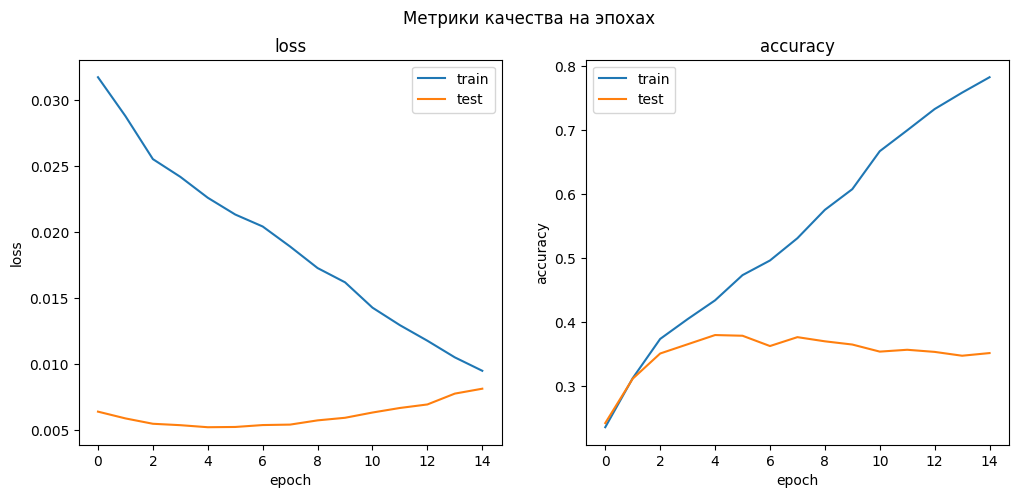

In [95]:
show_metrics(train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure)

**Время обучения: 180.793 секунд**

Нерегуляризованные LSTM часто быстро переобучаются (и мы это видим по точности на контроле). Чтобы с этим бороться, часто используют *L2-регуляризацию* и *дропаут*.
Однако способов накладывать дропаут на рекуррентный слой достаточно много, и далеко не все хорошо работают. По [ссылке](https://medium.com/@bingobee01/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b) доступен хороший обзор дропаутов для RNN.

Мы реализуем два варианта DropOut для RNN (и третий дополнительно). Заодно увидим, что для реализации различных усовершенствований рекуррентной архитектуры приходится "вскрывать" слой до различной "глубины".

## `Реализация дропаута по статье Гала и Гарамани. Variational Dropout (1 балл)`

Начнем с дропаута, описанного в [статье Гала и Гарамани](https://arxiv.org/abs/1512.05287).
Для этого нам потребуется перейти от использования слоя `torch.nn.LSTM`, полностью скрывающего от нас рекуррентную логику, к использованию слоя `torch.nn.LSTMCell`, обрабатывающего лишь один временной шаг нашей последовательности (а всю логику вокруг придется реализовать самостоятельно). 

Допишите класс `RNNLayer`. При `dropout=0` ваш класс должен работать как обычный слой LSTM, а при `dropout > 0` накладывать бинарную маску на входной и скрытый вектор на каждом временном шаге, причем эта маска должна быть одинаковой во все моменты времени.

Дропаут Гала и Гарамани в виде формул (m обозначает маску дропаута):

$$
h_{t-1} = h_{t-1}*m_h, \, x_t = x_t * m_x
$$

Далее обычный шаг рекуррентной архитектуры, например, LSTM:

$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t)
$$

In [8]:
def init_h0_c0(num_objects, hidden_size, some_existing_tensor):
    """
    return h0 and c0, use some_existing_tensor.new_zeros() to gen them
    h0 shape: num_objects x hidden_size
    c0 shape: num_objects x hidden_size
    """
    return some_existing_tensor.new_zeros((num_objects, hidden_size)), some_existing_tensor.new_zeros((num_objects, hidden_size))

In [9]:
def gen_dropout_mask(input_size, hidden_size, is_training, p, some_existing_tensor):
    """
    is_training: if True, gen masks from Bernoulli
                 if False, gen masks consisting of (1-p)
    
    return dropout masks of size input_size, hidden_size if p is not None
    return one masks if p is None
    """
    if p is None:
        # do not use any sort of dropout mask
        return some_existing_tensor.new_ones((input_size, hidden_size))
    else:
        if is_training:
            # use p as probabilty for zeroing each element
            return torch.bernoulli(some_existing_tensor.new_ones((input_size, hidden_size)) * (1 - p))
        else:
            # normalizing math expectancy of elements
            return some_existing_tensor.new_ones((input_size, hidden_size)) * (1 - p)

Допишите класс-обёртку над `LSTMCell` для реализации Variational Dropout. **Используйте только цикл по времени**

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [58]:
class RNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=None, num_layers=None):
        super().__init__()

        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.rnn_cell = torch.nn.LSTMCell(self.input_size, self.hidden_size)
        
    def forward(self, x):
        # Initialize h_0, c_0
        h_0, c_0 = init_h0_c0(x.shape[1], self.hidden_size, x)
        
        # Gen masks for input and hidden state
        mask_h = gen_dropout_mask(h_0.shape[0], h_0.shape[1], self.training, self.dropout, x)       # Batch_size x hidden_size
        mask_x = gen_dropout_mask(x.shape[1], self.input_size, self.training, self.dropout, x)      # Batch_size x input_size
        
        outputs = []
        
        # Implement recurrent logic and return what nn.LSTM returns
        # Do not forget to apply generated dropout masks!
        for row in x:                                                                               # get each time row in series
            new_h = h_0 * mask_h                                                                    # Batch_size x hidden_size
            new_x = row * mask_x                                                                    # Batch_size x input_size
            h_0, c_0 = self.rnn_cell(new_x, (new_h, c_0))
            outputs.append(h_0)
        
        return torch.stack(outputs), (h_0, c_0)

Протестируйте реализованную модель с выключенным дропаутом (слой `RNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Сильно ли оно увеличилось по сравнению с `torch.nn.LSTM` (LSTM "из коробки")?

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [51]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=RNNLayer, dropout=None
).to(device)

In [52]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [53]:
train_lossess_vardrop, train_accuracies_vardrop, test_losses_vardrop, test_accuracies_vardrop = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs,
    chunk=50, run_name='custom cell with no droput'
)

Epoch: 1/15. Loss (Train/Test): 0.032/0.006. Accuracy (Train/Test): 0.225/0.222
Epoch: 2/15. Loss (Train/Test): 0.028/0.006. Accuracy (Train/Test): 0.324/0.324
Epoch: 3/15. Loss (Train/Test): 0.026/0.005. Accuracy (Train/Test): 0.354/0.347
Epoch: 4/15. Loss (Train/Test): 0.025/0.005. Accuracy (Train/Test): 0.380/0.347
Epoch: 5/15. Loss (Train/Test): 0.023/0.005. Accuracy (Train/Test): 0.410/0.370
Epoch: 6/15. Loss (Train/Test): 0.022/0.005. Accuracy (Train/Test): 0.440/0.381
Epoch: 7/15. Loss (Train/Test): 0.021/0.005. Accuracy (Train/Test): 0.472/0.373
Epoch: 8/15. Loss (Train/Test): 0.020/0.005. Accuracy (Train/Test): 0.488/0.378
Epoch: 9/15. Loss (Train/Test): 0.019/0.005. Accuracy (Train/Test): 0.542/0.372
Epoch: 10/15. Loss (Train/Test): 0.018/0.006. Accuracy (Train/Test): 0.571/0.372
Epoch: 11/15. Loss (Train/Test): 0.017/0.006. Accuracy (Train/Test): 0.610/0.363
Epoch: 12/15. Loss (Train/Test): 0.016/0.006. Accuracy (Train/Test): 0.650/0.361
Epoch: 13/15. Loss (Train/Test): 0.01

eval/loss,█▄▃▂▁▁▁▂▂▃▄▅▅▆▇
eval/total_accuracy,▁▅▆▆▇█████▇▇▇▆▆
train/accuracy,▁▁▁▂▃▃▃▂▃▄▄▃▄▄▄▅▃▃▂▄▅▅▅▅▆▅▅▆▅▆▆▅▇▇▆▇█▆▇▇
train/loss,████▇▆▇▇▆▅▅▅▅▅▅▄▅▅▅▄▄▄▃▄▄▄▃▃▃▃▃▃▂▂▂▃▁▃▂▃
eval/loss,0.00633
eval/total_accuracy,0.33952
train/accuracy,0.71875
train/loss,1.00249


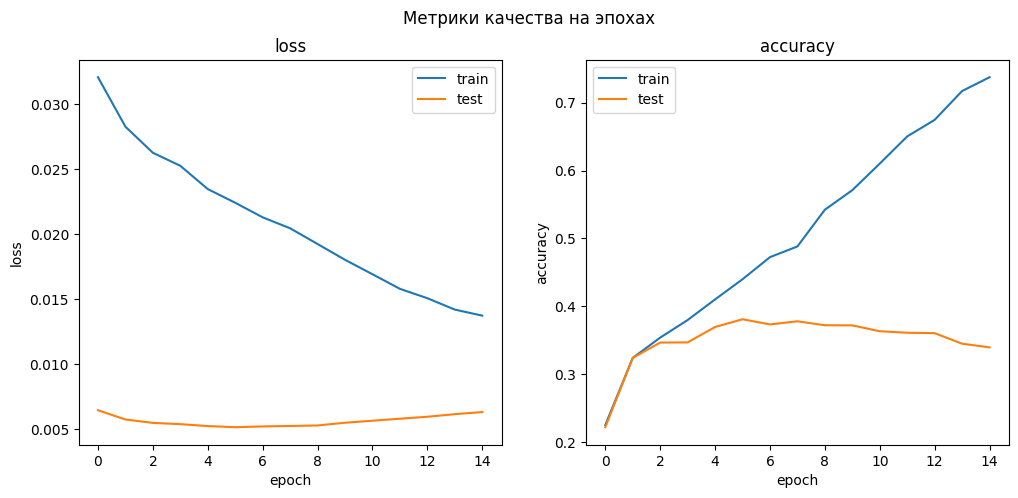

In [57]:
show_metrics(train_lossess_vardrop, train_accuracies_vardrop, test_losses_vardrop, test_accuracies_vardrop)

**Время обучения: 34.427 минут**

Протестируйте полученную модель с `dropout=0.25`, вновь замерив время обучения. Получилось ли побороть переобучение? Сильно ли дольше обучается данная модель по сравнению с предыдущей? (доп. время тратится на генерацию масок дропаута).

In [37]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=RNNLayer, dropout=0.25
).to(device)

In [38]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [39]:
train_lossess_vardrop_25, train_accuracies_vardrop_25, test_losses_vardrop_25, test_accuracies_vardrop_25 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs,
    chunk=50, run_name='vardrop 0.25'
)

Epoch: 1/15. Loss (Train/Test): 0.031/0.006. Accuracy (Train/Test): 0.278/0.286
Epoch: 2/15. Loss (Train/Test): 0.030/0.006. Accuracy (Train/Test): 0.313/0.322
Epoch: 3/15. Loss (Train/Test): 0.029/0.006. Accuracy (Train/Test): 0.333/0.336
Epoch: 4/15. Loss (Train/Test): 0.028/0.005. Accuracy (Train/Test): 0.351/0.347
Epoch: 5/15. Loss (Train/Test): 0.028/0.005. Accuracy (Train/Test): 0.363/0.356
Epoch: 6/15. Loss (Train/Test): 0.024/0.005. Accuracy (Train/Test): 0.393/0.363
Epoch: 7/15. Loss (Train/Test): 0.024/0.005. Accuracy (Train/Test): 0.404/0.372
Epoch: 8/15. Loss (Train/Test): 0.023/0.005. Accuracy (Train/Test): 0.420/0.383
Epoch: 9/15. Loss (Train/Test): 0.022/0.005. Accuracy (Train/Test): 0.439/0.383
Epoch: 10/15. Loss (Train/Test): 0.022/0.005. Accuracy (Train/Test): 0.451/0.387
Epoch: 11/15. Loss (Train/Test): 0.021/0.005. Accuracy (Train/Test): 0.465/0.389
Epoch: 12/15. Loss (Train/Test): 0.021/0.005. Accuracy (Train/Test): 0.478/0.390
Epoch: 13/15. Loss (Train/Test): 0.02

eval/loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁
eval/total_accuracy,▁▃▄▅▅▆▆▇▇▇█████
train/accuracy,▁▂▂▁▄▃▃▅▅▃▃▅▃▄▄▄▄▃▅▅▆▄▆▅▄▅▇▆▇▅▆▇▅▅▇▇█▆▅▅
train/loss,████▇▇▇▅▄▆▅▄▄▅▅▄▄▄▄▅▂▄▂▄▃▃▂▂▃▂▂▂▃▃▂▁▁▃▂▂
eval/loss,0.00502
eval/total_accuracy,0.3954
train/accuracy,0.4375
train/loss,1.36782


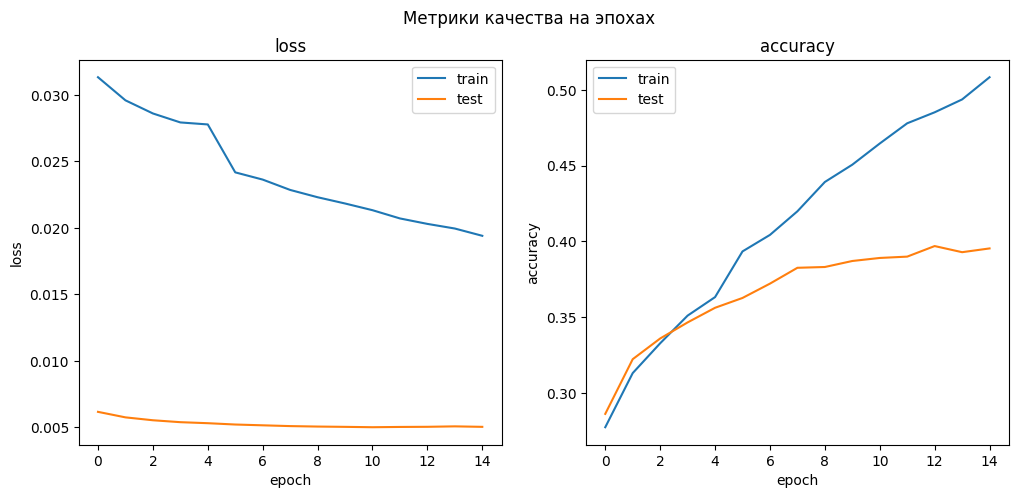

In [40]:
show_metrics(train_lossess_vardrop_25, train_accuracies_vardrop_25, test_losses_vardrop_25, test_accuracies_vardrop_25)

**Время обучения: 35.438 минут**

## `Реализация дропаута по статье Гала и Гарамани. Дубль 2 (1 балл)`

<начало взлома pytorch>

При разворачивании цикла по времени средствами python обучение рекуррентной нейросети сильно замедляется. Однако для реализации дропаута Гала и Гарамани необязательно явно задавать в коде умножение нейронов на маски. Можно схитрить и обойтись использованием слоя `torch.nn.LSTM`: перед вызовом `forward` слоя `torch.nn.LSTM` подменять его веса на веса, домноженные по строкам на маски. А обучаемые веса хранить отдельно. Именно так этот дропаут реализован в библиотеке `fastai`, код из которой использован в ячейке ниже.

Такой слой реализуется в виде обертки над `torch.nn.LSTM`. Допишите класс:

In [10]:
import warnings

class FastRNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0, layers_dropout=0.0, num_layers=1):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.num_layers = num_layers

        self.dropout = dropout
        self.layers_dropout = layers_dropout
        self.module = torch.nn.LSTM(input_size, hidden_size, dropout=layers_dropout, num_layers=num_layers)

        self.layer_names = []
        for layer_n in range(self.num_layers):
            self.layer_names += [f'weight_hh_l{layer_n}', f'weight_ih_l{layer_n}']

        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights from torch.nn.LSTM instance
            w = getattr(self.module, layer)

            # Remove it from model
            delattr(self.module, layer)

            # And create new torch.nn.Parameter with the same data but different name
            self.register_parameter(f'{layer}_raw', torch.nn.Parameter(w.data))

            # Note. In torch.nn.LSTM.forward parameter with name `layer` will be used
            #     so we must initialize it using `layer_raw` before forward pass

    def _setweights(self, x):
        """
            Apply dropout to the raw weights.
        """
        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights
            raw_w = getattr(self, f'{layer}_raw')

            # Generate mask (use function gen_dropout_mask)
            mask = gen_dropout_mask(raw_w.shape[0], raw_w.shape[1], self.training, self.dropout, x)
            
            # Apply dropout mask
            masked_raw_w = mask * raw_w
            
            # Set modified weights in its place
            setattr(self.module, layer, masked_raw_w)

    def forward(self, x, h_c=None):
        """
        :param x: tensor containing the features of the input sequence.
        :param Optional[Tuple[torch.Tensor, torch.Tensor]] h_c: initial hidden state and initial cell state
        """
        with warnings.catch_warnings():
            # To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")

            # Set new weights of self.module and call its forward
            # Pass h_c with x if it is not None. Otherwise pass only x
            self._setweights(x)
            
            return self.module(x, h_c) if h_c is not None else self.module(x)
            
            
    def reset(self):
        if hasattr(self.module, 'reset'):
            self.module.reset()

Протестируйте реализованную модель с выключенным дропаутом (слой `FastRNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Убедитесь, что модель выдаёт такое же качество, как и оригинальная реализация LSTM.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [29]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=FastRNNLayer, dropout=None
).to(device)

In [30]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
train_lossess_fast_cell, train_accuracies_fast_cell, test_losses_fast_cell, test_accuracies_fast_cell = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs,
    chunk=50, run_name='fast cell no drop'
)

Epoch: 1/15. Loss (Train/Test): 0.031/0.006. Accuracy (Train/Test): 0.266/0.277
Epoch: 2/15. Loss (Train/Test): 0.029/0.006. Accuracy (Train/Test): 0.319/0.322
Epoch: 3/15. Loss (Train/Test): 0.027/0.005. Accuracy (Train/Test): 0.357/0.342
Epoch: 4/15. Loss (Train/Test): 0.026/0.005. Accuracy (Train/Test): 0.380/0.346
Epoch: 5/15. Loss (Train/Test): 0.025/0.005. Accuracy (Train/Test): 0.415/0.368
Epoch: 6/15. Loss (Train/Test): 0.024/0.005. Accuracy (Train/Test): 0.447/0.372
Epoch: 7/15. Loss (Train/Test): 0.023/0.005. Accuracy (Train/Test): 0.476/0.376
Epoch: 8/15. Loss (Train/Test): 0.022/0.006. Accuracy (Train/Test): 0.495/0.370
Epoch: 9/15. Loss (Train/Test): 0.021/0.006. Accuracy (Train/Test): 0.530/0.377
Epoch: 10/15. Loss (Train/Test): 0.020/0.006. Accuracy (Train/Test): 0.578/0.369
Epoch: 11/15. Loss (Train/Test): 0.019/0.006. Accuracy (Train/Test): 0.614/0.365
Epoch: 12/15. Loss (Train/Test): 0.018/0.007. Accuracy (Train/Test): 0.649/0.354
Epoch: 13/15. Loss (Train/Test): 0.01

eval/loss,▃▂▁▁▁▁▁▂▂▂▃▄▅▆█
eval/total_accuracy,▁▄▆▆▇████▇▇▆▆▅▆
train/accuracy,▁▂▁▂▁▃▁▄▃▂▃▂▃▄▃▃▄▄▄▅▅▃▃▄▅▄▅▅▄▆▆▄▆▆█▅▆▇▆█
train/loss,███▇█▆▇▆▆▆▆▆▆▅▆▅▅▅▄▄▄▅▅▄▄▅▃▃▄▃▃▄▂▂▁▃▂▂▂▁
eval/loss,0.00815
eval/total_accuracy,0.34336
train/accuracy,0.79688
train/loss,0.66223


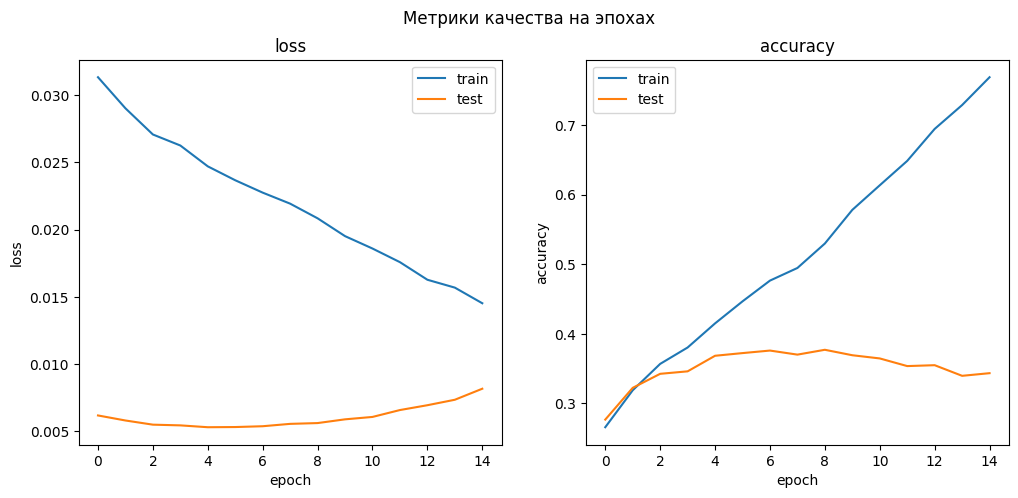

In [32]:
show_metrics(train_lossess_fast_cell, train_accuracies_fast_cell, test_losses_fast_cell, test_accuracies_fast_cell)

**Время обучения: 3.512 минут**

Протестируйте полученный слой (вновь подставив его в `RNNClassifier` в качестве `rec_layer`) с `dropout=0.25`. Сравните время обучения с предыдущими моделями. Проследите, чтобы качество получилось такое же, как при первой реализации этого дропаута.

In [33]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=FastRNNLayer, dropout=0.25
).to(device)

In [34]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [35]:
train_lossess_fast_cell25, train_accuracies_fast_cell25, test_losses_fast_cell25, test_accuracies_fast_cell25 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs,
    chunk=50, run_name='fast cell vardrop 0.25'
)

Epoch: 1/15. Loss (Train/Test): 0.032/0.006. Accuracy (Train/Test): 0.257/0.272
Epoch: 2/15. Loss (Train/Test): 0.031/0.006. Accuracy (Train/Test): 0.306/0.317
Epoch: 3/15. Loss (Train/Test): 0.030/0.006. Accuracy (Train/Test): 0.337/0.329
Epoch: 4/15. Loss (Train/Test): 0.029/0.005. Accuracy (Train/Test): 0.359/0.349
Epoch: 5/15. Loss (Train/Test): 0.028/0.005. Accuracy (Train/Test): 0.373/0.356
Epoch: 6/15. Loss (Train/Test): 0.029/0.006. Accuracy (Train/Test): 0.374/0.361
Epoch: 7/15. Loss (Train/Test): 0.027/0.005. Accuracy (Train/Test): 0.408/0.369
Epoch: 8/15. Loss (Train/Test): 0.028/0.005. Accuracy (Train/Test): 0.414/0.371
Epoch: 9/15. Loss (Train/Test): 0.028/0.006. Accuracy (Train/Test): 0.425/0.370
Epoch: 10/15. Loss (Train/Test): 0.027/0.005. Accuracy (Train/Test): 0.446/0.368
Epoch: 11/15. Loss (Train/Test): 0.027/0.006. Accuracy (Train/Test): 0.448/0.378
Epoch: 12/15. Loss (Train/Test): 0.027/0.006. Accuracy (Train/Test): 0.467/0.380
Epoch: 13/15. Loss (Train/Test): 0.02

eval/loss,█▅▄▂▂▃▁▂▃▂▃▃▄▄▄
eval/total_accuracy,▁▄▅▆▆▇▇▇▇▇██▇▇█
train/accuracy,▃▁▂▃▄▄▅▄▅▄▃▅▆▆▄▅▅▄▅▆▅▇▇█▅▅▇▅▅█▆▇█▆█▇█▇█▆
train/loss,▇██▇▆▆▅▅▅▄▆▅▅▅▄▅▅▆▅▃▅▄▃▂▄▄▂▄▄▂▃▃▂▃▂▃▁▃▂▃
eval/loss,0.00574
eval/total_accuracy,0.38276
train/accuracy,0.45312
train/loss,1.27067


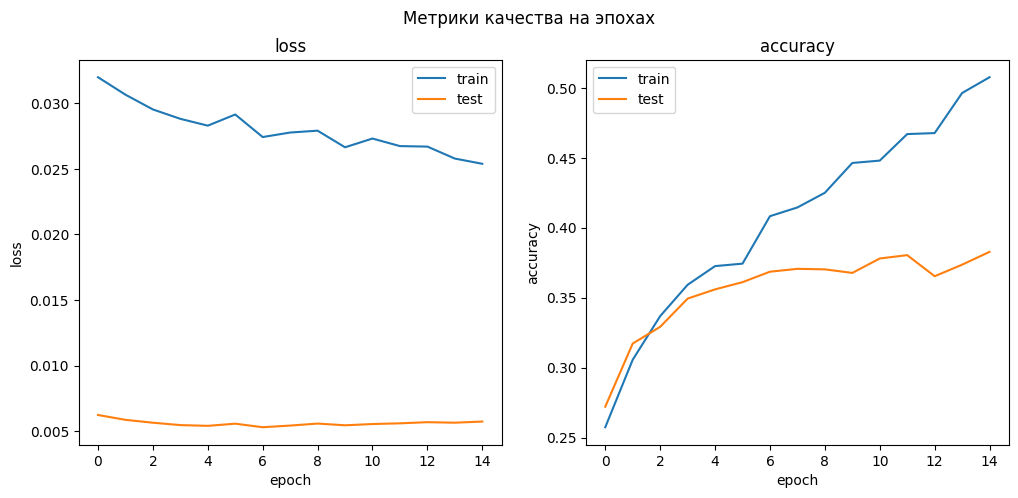

In [36]:
show_metrics(train_lossess_fast_cell25, train_accuracies_fast_cell25, test_losses_fast_cell25, test_accuracies_fast_cell25)

**Время обучения: 3.536 минут**

</конец взлома pytorch>

## `Реализация дропаута по статье Семениуты и др. (1 балл)`

Перейдем к реализации дропаута для LSTM по статье [Semeniuta et al](http://www.aclweb.org/anthology/C16-1165). 

Этот метод применения дропаута не менее популярен, чем предыдущий. Его особенность состоит в том, что он придуман специально для гейтовых архитектур. В контексте LSTM этот дропаут накладывается только на информационный поток ($m_h$ — маска дропаута):
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot g \odot {\bf m_h} \quad
h_t =  o \odot tanh(c_t)
$$
На входы $x_t$ маска накладывается как в предыдущем дропауте. Впрочем, на входы маску можно наложить вообще до вызова рекуррентного слоя.

Согласно статье, маска дропаута может быть как одинаковая, так и разная для всех моментов времени. Мы сделаем одинаковую для всех моментов времени.

Для реализации этого дропаута можно: 
1. самостоятельно реализовать LSTM (интерфейса LSTMCell не хватит) 
2. снова воспользоваться трюком с установкой весов (но тут мы опираемся на свойство $tanh(0)=0$, к тому же, трюк в данном случае выглядит менее тривиально, чем с дропаутом Гала). 

Предлагается реализовать дропаут по сценарию 1. Допишите класс:

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [16]:
from torch import sigmoid, tanh

class HandmadeLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0, num_layers=None):
        super().__init__()
        
        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.input_weights = torch.nn.Linear(input_size, 4 * hidden_size)
        self.hidden_weights = torch.nn.Linear(hidden_size, 4 * hidden_size)
        
        self.reset_params()

    def reset_params(self):
        """
        Initialization as in Pytorch. 
        Do not forget to call this method!
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#LSTM
        """
        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            torch.nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x):
        # Use functions init_h0_c0 and gen_dropout_masks defined above
        h_0, c_0 = init_h0_c0(x.shape[1], self.hidden_size, x)
        
        # make one mask for batch
        mask = gen_dropout_mask(x.shape[1], self.hidden_size, self.training, self.dropout, x)
        
        outputs = []
        
        # Implement recurrent logic to mimic torch.nn.LSTM
        # Do not forget to apply dropout mask
        for row in x:
            C = self.input_weights(row)
            H = self.hidden_weights(h_0)

            c_i, c_o, c_f, c_g = torch.split(C, split_size_or_sections=self.hidden_size, dim=-1)
            h_i, h_o, h_f, h_g = torch.split(H, split_size_or_sections=self.hidden_size, dim=-1)
            
            i, o, f, g = sigmoid(c_i + h_i), sigmoid(c_o + h_o), sigmoid(c_f + h_f), tanh(c_g + h_g)
            
            c_0 = f * c_0 + i * g * mask
            h_0 = o * tanh(c_0)
            
            outputs.append(h_0)
            
        return torch.stack(outputs), (h_0, c_0)

Протестируйте вашу реализацию без дропаута (проконтролируйте качество и сравните время обучения с временем обучения `torch.nn.LSTM` и `RNNLayer`), а также с `dropout=0.25`. Сравните качество модели с таким дропаутом с качеством модели с дропаутом Гала и Гарамани.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [32]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=HandmadeLSTM, dropout=None
).to(device)

In [33]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [35]:
train_lossess_semeniut, train_accuracies_semeniut, test_losses_semeniut, test_accuracies_semeniut = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs,
    chunk=50, run_name='LSTM cell semeniut no droput'
)
torch.mps.empty_cache()

Epoch: 1/15. Loss (Train/Test): 0.031/0.006. Accuracy (Train/Test): 0.267/0.265
Epoch: 2/15. Loss (Train/Test): 0.027/0.006. Accuracy (Train/Test): 0.337/0.328
Epoch: 3/15. Loss (Train/Test): 0.025/0.005. Accuracy (Train/Test): 0.375/0.344
Epoch: 4/15. Loss (Train/Test): 0.024/0.005. Accuracy (Train/Test): 0.393/0.354
Epoch: 5/15. Loss (Train/Test): 0.023/0.005. Accuracy (Train/Test): 0.428/0.359
Epoch: 6/15. Loss (Train/Test): 0.022/0.005. Accuracy (Train/Test): 0.455/0.374
Epoch: 7/15. Loss (Train/Test): 0.020/0.005. Accuracy (Train/Test): 0.483/0.374
Epoch: 8/15. Loss (Train/Test): 0.020/0.005. Accuracy (Train/Test): 0.511/0.369
Epoch: 9/15. Loss (Train/Test): 0.018/0.006. Accuracy (Train/Test): 0.536/0.378
Epoch: 10/15. Loss (Train/Test): 0.017/0.006. Accuracy (Train/Test): 0.589/0.361
Epoch: 11/15. Loss (Train/Test): 0.015/0.006. Accuracy (Train/Test): 0.629/0.365
Epoch: 12/15. Loss (Train/Test): 0.014/0.006. Accuracy (Train/Test): 0.675/0.359
Epoch: 13/15. Loss (Train/Test): 0.01

eval/loss,▄▂▂▁▁▁▁▁▂▃▃▄▆▇█
eval/total_accuracy,▁▅▆▇▇██▇█▇▇▇▆▆▅
train/accuracy,▁▂▂▃▂▄▃▃▃▅▄▅▅▄▃▄▅▃▅▅▅▅▆▅▅▅▆▇▆▇▇▇▇▇▆▆▆██▇
train/loss,███▇▇▆▅▆▆▅▆▅▅▅▅▅▄▅▄▃▃▃▄▄▃▃▃▃▂▂▂▂▂▃▂▂▃▁▁▂
eval/loss,0.00783
eval/total_accuracy,0.33764
train/accuracy,0.70312
train/loss,0.82538


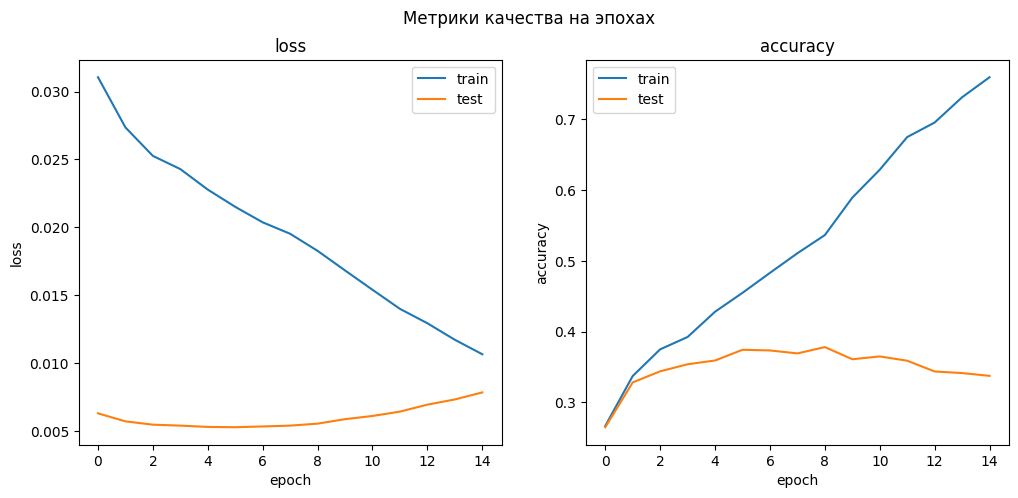

In [37]:
show_metrics(train_lossess_semeniut, train_accuracies_semeniut, test_losses_semeniut, test_accuracies_semeniut)

**Время обучения: 38.525 минут**

In [47]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=HandmadeLSTM, dropout=0.25
).to(device)

In [48]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [49]:
train_lossess_semeniut25, train_accuracies_semeniut25, test_losses_semeniut25, test_accuracies_semeniut25 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs,
    chunk=50, run_name='LSTM cell semeniut 0.25'
)
torch.mps.empty_cache()

Epoch: 1/15. Loss (Train/Test): 0.032/0.006. Accuracy (Train/Test): 0.175/0.205
Epoch: 2/15. Loss (Train/Test): 0.028/0.006. Accuracy (Train/Test): 0.322/0.322


wandb: Network error (ConnectionError), entering retry loop.


Epoch: 3/15. Loss (Train/Test): 0.026/0.006. Accuracy (Train/Test): 0.346/0.336
Epoch: 4/15. Loss (Train/Test): 0.025/0.005. Accuracy (Train/Test): 0.365/0.345
Epoch: 5/15. Loss (Train/Test): 0.024/0.005. Accuracy (Train/Test): 0.379/0.347
Epoch: 6/15. Loss (Train/Test): 0.023/0.005. Accuracy (Train/Test): 0.405/0.363
Epoch: 7/15. Loss (Train/Test): 0.023/0.005. Accuracy (Train/Test): 0.421/0.357
Epoch: 8/15. Loss (Train/Test): 0.022/0.005. Accuracy (Train/Test): 0.435/0.367
Epoch: 9/15. Loss (Train/Test): 0.021/0.005. Accuracy (Train/Test): 0.457/0.372
Epoch: 10/15. Loss (Train/Test): 0.021/0.006. Accuracy (Train/Test): 0.468/0.371
Epoch: 11/15. Loss (Train/Test): 0.020/0.006. Accuracy (Train/Test): 0.489/0.372
Epoch: 12/15. Loss (Train/Test): 0.020/0.006. Accuracy (Train/Test): 0.501/0.362
Epoch: 13/15. Loss (Train/Test): 0.019/0.006. Accuracy (Train/Test): 0.520/0.368
Epoch: 14/15. Loss (Train/Test): 0.018/0.006. Accuracy (Train/Test): 0.533/0.372
Epoch: 15/15. Loss (Train/Test): 0.

eval/loss,█▄▃▂▂▁▁▂▁▂▃▄▄▅▆
eval/total_accuracy,▁▆▇▇▇█▇████████
train/accuracy,▁▁▃▃▃▄▃▄▅▅▅▄▅▄▄▃▅▆▄▅▅▆▆▅▆▅▇▆▆▇▅▅▇▅▆▅▆█▆▅
train/loss,██▇▇▇▆▇▆▆▄▅▅▅▆▄▅▄▄▅▄▄▄▃▃▃▄▂▃▂▂▄▃▃▃▂▄▂▁▃▃
eval/loss,0.00612
eval/total_accuracy,0.36824
train/accuracy,0.4375
train/loss,1.34082


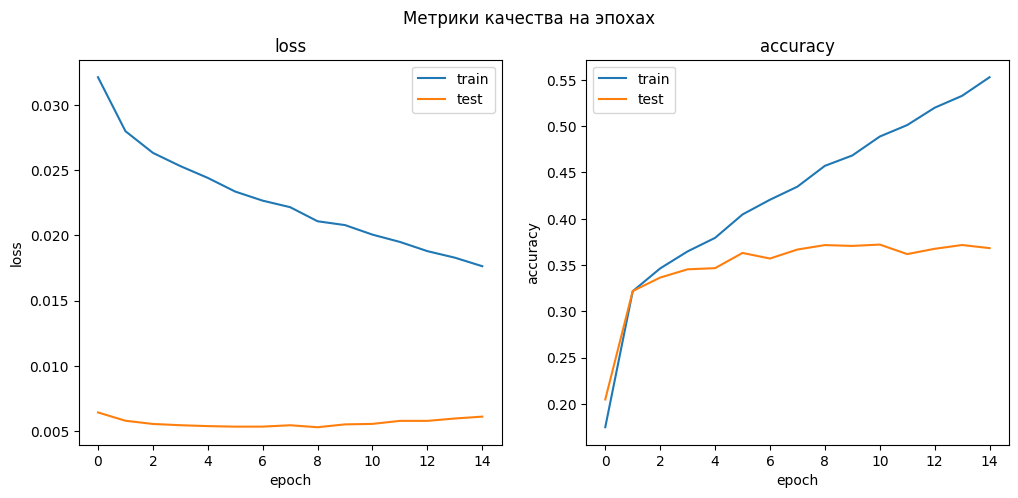

In [50]:
show_metrics(train_lossess_semeniut25, train_accuracies_semeniut25, test_losses_semeniut25, test_accuracies_semeniut25)

## `Сравнение всех предложенных моделей (1 балл)`

Используя замеры времени заполните табличку с временем работы четырёх реализованных моделей в следующей ячейке:

| torch.nn.LSTM | RNNLayer | FastRNNLayer | HandmadeLSTM |
|---------------|----------|--------------|--------------|
| 2m 35s        | 14m 16s  | 2m 41s       | 31m 44s      |

In [43]:
import matplotlib.pyplot as plt

Крайне желательно рисовать графики в векторном формате. 

Если по каким-то причинам, отрисовка не будет работать, закомментируйте следующую ячейку.

In [44]:
%matplotlib inline

import matplotlib_inline
from IPython.display import set_matplotlib_formats

matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

Нарисуйте два графика — функция потерь и качество на обучающей и тестовой выборке для всех 7 моделей обученных выше.

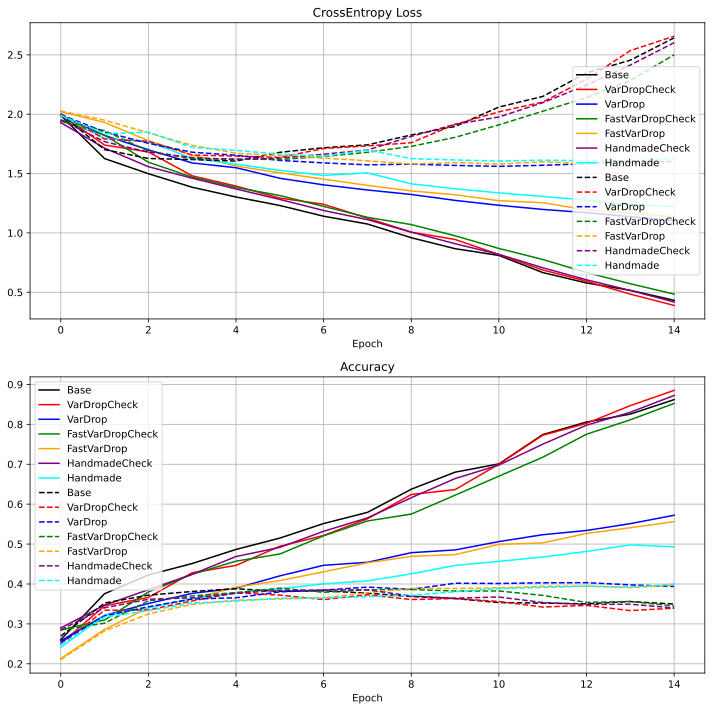

In [45]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# YOUR CODE HERE
...

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('CrossEntropy Loss')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Сделайте итоговые выводы о качестве работы моделей с разными реализациями DropOut:

**Ответ:**

## `Бонус. Zoneout (0.5 балла)`

Это еще одна модификация идеи дропаута применительно к рекуррентным нейросетям. В Zoneout на каждом временном шаге с вероятностью $p$ компонента скрытого состояния обновляется, а с вероятностью $1-p$ берется с предыдущего шага. 
В Виде формул ($m^t_h$ - бинарная маска):
 
(сначала обычный рекуррентный переход, например LSTM)
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t)
$$
Затем Zoneout:
$$
h_t = h_t * m_h^t + h_{t-1}*(1-m_h^t)
$$
В этом методе маска уже должна быть разная во все моменты времени (иначе метод упрощается до дропаута Гала и Гарамани). На входы $x_t$ вновь можно накладывать маску до начала работы рекуррентного слоя.  

Если у вас осталось время, вы можете реализовать этот метод. Выберите основу из трех рассмотренных случаев самостоятельно.

**Полный балл ставится только при наличии качественного и количественного сравнения с предыдущими моделями.**

In [ ]:
from torch import sigmoid, tanh

class LSTMZoneOut(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0, num_layers=None):
        super().__init__()
        
        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.input_weights = torch.nn.Linear(input_size, 4 * hidden_size)
        self.hidden_weights = torch.nn.Linear(hidden_size, 4 * hidden_size)
        
        self.reset_params()

    def reset_params(self):
        """
        Initialization as in Pytorch. 
        Do not forget to call this method!
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#LSTM
        """
        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            torch.nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x):
        # Use functions init_h0_c0 and gen_dropout_masks defined above
        h_0, c_0 = init_h0_c0(x.shape[1], self.hidden_size, x)
        
        outputs = []
        
        # Implement recurrent logic to mimic torch.nn.LSTM
        # Do not forget to apply dropout mask
        for row in x:
            C = self.input_weights(row)
            H = self.hidden_weights(h_0)

            c_i, c_o, c_f, c_g = torch.split(C, split_size_or_sections=self.hidden_size, dim=-1)
            h_i, h_o, h_f, h_g = torch.split(H, split_size_or_sections=self.hidden_size, dim=-1)
            
            i, o, f, g = sigmoid(c_i + h_i), sigmoid(c_o + h_o), sigmoid(c_f + h_f), tanh(c_g + h_g)
            
            c_0 = f * c_0 + i * g
            h_1 = o * tanh(c_0)
            
            mask = gen_dropout_mask(h_1.shape[0], h_1.shape[1], self.training, self.dropout, h_1)
            
            h_0 = h_1 * mask + h_0 * (1 - mask)
            
            outputs.append(h_0)
            
        return torch.stack(outputs), (h_0, c_0)

# `Часть 2. Language Modeling с помощью LSTM (5 баллов)`

Во второй части мы попробуем обучить модель для генерации отзывов по их началу.

Концептуально модель будет выглядеть следующим образом:
    
![image info](https://blog.feedly.com/wp-content/uploads/2019/03/Screen-Shot-2019-03-06-at-12.08.35-PM.png)

В процессе обучения будем тренировать сеть предсказывать вероятность следующего символа при условии всех предыдущих. Эту вероятность можно моделировать с помощью скрытого состояния $h^{(t)}$ пропуская его через линейный слой с выходной размерностью равной размерности словаря:
$$
p(x^{t}|x^{t-1}, ..., x^{1}) = SoftMax(Linear(h^{(t)}))
$$

Обратите внимание, что для вычисления $p(x^{t}|x^{t-1}, ..., x^{1})$ для всех моментов времени достаточно сделать один проход по RNN, а затем применить линейное преобразование ко всем скрытым состояниям.

В качестве функции потерь необходимо использовать `CrossEntropy`.

Рассмотрим другой важный момент. Для того, чтобы решить данную задачу, модель должна уметь определять момент начала генерации предложения и оповещать о завершении генерации — конце предложения. Для этого добавим в словарь вспомогательные токены `<sos>`, `<eos>`. Добавив `<sos>` в начало каждого предложения и `<eos>` в конец.

Модель сможет начинать генерацию как только ей будет передан токен `<sos>` и заканчивать генерацию, как только на очередном месте самым вероятным токеном оказывается `<eos>`.

Для решения этой задачи мы воспользуемся уже реализованной LSTM с дропаутом `FastRNNLayer` и классом `RNNClassifier`, то есть архитектура сети принципиально не поменяется. 

In [11]:
dtype, device, cuda_device_id = torch.float32, None, 0
os.environ["CUDA_VISIBLE_DEVICES"] = '{0}'.format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = 'cuda:{0:d}'.format(0)
elif torch.backends.mps.is_available():
    device = torch.device('mps:0')
else:
    device = torch.device('cpu')
print(f'Using device: {device}, dtype: {dtype}')

Using device: mps:0, dtype: torch.float32


In [12]:
max_length = 200
top_n_words = 5000

hidden_dim = 128
embedding_dim = 32

num_epochs = 15
batch_size = 64
learning_rate = 1e-3

In [13]:
test_data_path = './aclImdb/test/'
train_data_path = './aclImdb/train/'

## `Реализация модели и цикла обучения (2 балла)`

**Не используйте циклы в `RNNLM`, `LMCrossEntropyLoss`, `LMAccuracy`**

In [14]:
class RNNLM(RNNClassifier):
    def __init__(
        self, embedding_dim, hidden_dim, vocab, dropout=0.5, layers_dropout=0.5, num_layers=1
    ):
        super().__init__(
            embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=len(vocab), vocab=vocab,
            rec_layer=FastRNNLayer, num_classes=len(vocab), dropout=dropout, layers_dropout=layers_dropout, num_layers=num_layers
        )
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.Tensor(dtype=torch.long) tokens: 
            Batch of texts represented with tokens. Shape: [T, B]
        :param torch.Tensor(dtype=torch.long) tokens_lens: 
            Number of non-padding tokens for each object in batch. Shape: [B]
        :return torch.Tensor: 
            Distribution of next token for each time step. Shape: [T, B, V], V — size of vocabulary
        """
        # Make embeddings for all tokens
        embeds = self.word_embeddings(tokens)
        
        # Forward pass embeddings through network
        outputs, (hidden, cell_state) = self.rnn(embeds)
        
        # Take all hidden states from the last layer of LSTM for each step and perform linear transformation
        return self.output(outputs)

Реализуем функцию потерь для данной задачи. 

Моменты на которые нужно обратить внимание:
1. Распределение вероятности следующего токена для последнего токена в последовательности не участвует в подсчёте функции потерь.
2. Необходимо учитывать, что в одном батче могут быть тексты разной длины.

Для решения второй проблемы можно воспользоваться функцией `torch.nn.utils.rnn.pack_padded_sequence`. 

Принимая на вход батч тензоров и длину каждого тензора без учёта паддинга эта функция позволяет получить все элементы в тензорах, которые не относятся к паддингу в виде плоского массива:

In [11]:
padded_tensors = torch.tensor([
    [[1, 11, 111], [2, 22, 222], [3, 33, 333]],
    [[4, 44, 444], [5, 55, 555], [6, 66, 666]],
    [[7, 77, 777], [0, 0, 0],    [8, 88, 888]],
    [[9, 99, 999], [0, 0, 0],    [0, 0, 0]]
])
tensors_lens = torch.tensor([4, 2, 3])

Обратите внимание, что `torch.nn.utils.rnn.pack_padded_sequence` автоматически переупорядочивает тензоры в батче по убыванию их длины.

In [12]:
torch.nn.utils.rnn.pack_padded_sequence(padded_tensors, tensors_lens, batch_first=False, enforce_sorted=False)

PackedSequence(data=tensor([[  1,  11, 111],
        [  3,  33, 333],
        [  2,  22, 222],
        [  4,  44, 444],
        [  6,  66, 666],
        [  5,  55, 555],
        [  7,  77, 777],
        [  8,  88, 888],
        [  9,  99, 999]]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

In [15]:
class LMCrossEntropyLoss(torch.nn.CrossEntropyLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.Tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.Tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.Tensor tokens_lens: Length of each sequence in batch
        :return torch.Tensor: CrossEntropyLoss between corresponding logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first 
        # YOUR CODE HERE
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(outputs, tokens_lens, batch_first=False, enforce_sorted=False)
        packed_tokens  = torch.nn.utils.rnn.pack_padded_sequence(tokens,  tokens_lens, batch_first=False, enforce_sorted=False)
        
        # Use super().forward(..., ...) to compute CrossEntropyLoss
        return super().forward(packed_outputs.data, packed_tokens.data)

Для оценки качества нам также необходимо вычислять долю правильно предсказанных токенов. Реализуйте класс для вычисления точности.

In [16]:
class LMAccuracy(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.Tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.Tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.Tensor tokens_lens: Length of each sequence in batch
        :return torch.Tensor: Accuracy for given logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first 
        # YOUR CODE HERE
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(outputs, tokens_lens, batch_first=False, enforce_sorted=False)
        packed_tokens  = torch.nn.utils.rnn.pack_padded_sequence(tokens,  tokens_lens, batch_first=False, enforce_sorted=False)
        
        preds = torch.argmax(packed_outputs.data, dim=-1)
        return torch.sum(preds == packed_tokens.data) / tokens.numel()

Модифицируйте функции `train_epoch`, `evaluate`, `train` для обучения LM.

**При вычислении точности, обратите внимание на то, что мы не предсказываем первый токен в каждой последовательности и токены, относящиеся к паддингу.**

In [38]:
def train_epoch_lm(dataloader, model, loss_fn, optimizer, device, step, chunk):
    model.train()
    accuracy_fn = LMAccuracy()
    
    for idx, data in enumerate(dataloader):
        optimizer.zero_grad()
        # 1. Take data from batch
        tokens, lenghts  = data['tokens'].to(device), data['tokens_lens']
        # 2. Perform forward pass
        preds = model(tokens, lenghts)
        # 3. Evaluate loss
        loss = loss_fn(preds, tokens, lenghts)
        # 4. Make optimizer step
        loss.backward()
        optimizer.step()
        
        step += 1
        if step % chunk == 0:
            wandb.log({"train/loss": loss, "train/accuracy": accuracy_fn(preds, tokens, lenghts).item()}, step=step)
    
    return step
    
def evaluate_lm(dataloader, model, loss_fn, device, step):
    model.eval()
    
    total_tokens = 0
    total_loss = 0.0
    total_accuracy = 0.0
    
    accuracy_fn = LMAccuracy()
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            tokens, lenghts  = data['tokens'].to(device), data['tokens_lens']
            # 2. Perform forward pass
            preds = model(tokens, lenghts)
            # 3. Evaluate loss
            total_loss += loss_fn(preds, tokens, lenghts).item() * tokens.numel()
            # 4. Evaluate accuracy
            total_accuracy += accuracy_fn(preds, tokens, lenghts).item() * tokens.numel()
            
            total_tokens += tokens.numel()

            
    if step is not None:
        wandb.log({"eval/loss": total_loss / total_tokens, "eval/total_accuracy": total_accuracy / total_tokens}, step=step)
            
    return total_loss / total_tokens, total_accuracy / total_tokens

def train_lm(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs,
    chunk, run_name, project_name='PRAC_RNN', 
):
    wandb.init(project=project_name, name=run_name)
    global_step = 1
    
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        global_step = train_epoch_lm(train_loader, model, loss_fn, optimizer, device, global_step, chunk)
        
        train_loss, train_acc = evaluate_lm(train_loader, model, loss_fn, device, global_step)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate_lm(test_loader, model, loss_fn, device, None)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Теперь у нас всё готово для обучения модели.

Создадим словарь с `<sos>`, `<eos>` токенами.

Обратите внимание, что в отличие от классификации текстов нам необходимо значительно увеличить размер словаря, чтобы доля `<unk>` токенов была не велика.

Так же, так как задача генерации значительно сложнее задачи классификации текстов будем обучать модель только на префиксах рецензий длины $20$. Это позволяет значительно ускорить обучение.

In [24]:
with open('./counter.dll', 'rb') as f:
    counter = dill.load(f)
with open('./vocab.dll', 'rb') as f:
    vocab = dill.load(f)

In [25]:
specials = ['<pad>', '<unk>', '<sos>', '<eos>']
for special in specials:
    counter[special] = 0
# min_freq=8 is approximately equivalent to max_size=30000. 
#   You can lower min_freq in order to make model vocabulary more diverse 
lm_vocab = torchtext.vocab.vocab(counter, specials=specials, special_first=True, min_freq=8)
lm_vocab.set_default_index(vocab['<unk>'])

In [22]:
lm_test_dataset = LargeMovieReviewDataset(test_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)
lm_train_dataset = LargeMovieReviewDataset(train_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)

In [24]:
# with open('./lm_test_dataset.dll', 'wb') as f:
#     dill.dump(lm_test_dataset, f)
# with open('./lm_train_dataset.dll', 'wb') as f:
#     dill.dump(lm_train_dataset, f)

In [ ]:
with open('./lm_test_dataset.dll', 'rb') as f:
    lm_test_dataset = dill.load(f)
with open('./lm_train_dataset.dll', 'rb') as f:
    lm_train_dataset = dill.load(f)

Создадим даталоадеры для тестовой и обучающей выборок:

In [44]:
from functools import partial

lm_test_dataloader = DataLoader(
    lm_test_dataset, batch_size=196, shuffle=False, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)
lm_train_dataloader = DataLoader(
    lm_train_dataset, batch_size=196, shuffle=True, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)

In [47]:
# with open('./lm_test_dataloader.dll', 'wb') as f:
#     dill.dump(lm_test_dataloader, f)
# with open('./lm_train_dataloader.dll', 'wb') as f:
#     dill.dump(lm_train_dataloader, f)

In [18]:
with open('./lm_test_dataloader.dll', 'rb') as f:
    lm_test_dataloader = dill.load(f)
with open('./lm_train_dataloader.dll', 'rb') as f:
    lm_train_dataloader = dill.load(f)

In [19]:
batch = next(iter(lm_test_dataloader))
batch.keys(), batch['labels'], batch['ratings'], batch['tokens'], batch['tokens_lens']

(dict_keys(['ratings', 'labels', 'texts', 'tokens', 'tokens_lens']),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]),
 tensor([3, 0, 3, 1, 0, 3, 1, 3, 2, 3, 0, 0, 0, 3, 1, 0, 0, 1, 3, 1, 3, 0, 1, 0,
         2, 0, 1, 2, 1, 1, 0, 3, 0, 1, 3, 0, 0, 0, 3, 0, 0, 3, 3, 0, 0, 2, 0, 2,
         0, 2, 0, 2, 0, 0, 1, 3, 2, 0, 0, 2, 2, 1, 3, 0, 1, 2, 3, 3, 0, 3, 0, 0,
         0, 0, 0,

In [22]:
batch = next(iter(lm_train_dataloader))
batch.keys(), batch['labels'], batch['ratings'], batch['tokens'], batch['tokens_lens']

(dict_keys(['ratings', 'labels', 'texts', 'tokens', 'tokens_lens']),
 tensor([1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
         1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
         0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
         1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
         0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
         1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
         0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
         0, 0, 1, 0]),
 tensor([6, 9, 2, 0, 0, 0, 9, 2, 7, 1, 1, 3, 0, 3, 7, 2, 2, 9, 9, 2, 9, 9, 2, 0,
         9, 9, 9, 1, 7, 1, 7, 0, 8, 0, 3, 3, 0, 7, 9, 3, 8, 0, 9, 0, 8, 8, 2, 7,
         1, 3, 3, 9, 3, 9, 9, 8, 8, 9, 9, 2, 7, 3, 2, 7, 7, 8, 0, 9, 9, 8, 0, 7,
         9, 9, 3,

Убедитесь, что все предложения имеют в начале `<sos>` токен, а в конце — `<eos>` токен.

In [22]:
print(lm_vocab.lookup_indices(['<sos>', '<eos>']), )
batch = next(iter(lm_train_dataloader))
batch['tokens'], batch['tokens_lens']

[2, 3]


(tensor([[    2,     2,     2,  ...,     2,     2,     2],
         [ 4071,    32,   628,  ...,     1,    36,  1436],
         [ 1407,  1035,   983,  ...,  9789,   878,  1436],
         ...,
         [    1,    36,  2434,  ..., 23103,    36,   232],
         [    1,   881,   950,  ...,  1059,  8585,    47],
         [    3,     3,     3,  ...,     3,     3,     3]]),
 tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 18, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

Создадим модель, функцию потерь и оптимизатор: 

In [53]:
lm_model = RNNLM(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, dropout=0.6, layers_dropout=0.6, num_layers=2
).to(device=device)

In [54]:
lm_loss_fn = LMCrossEntropyLoss(reduction='mean')
lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=0.005, weight_decay=1.2e-6)

Обучим модель:

In [51]:
lm_model = torch.compile(lm_model)

In [56]:
lm_train_losses, lm_train_accuracies, lm_test_losses, lm_test_accuracies = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, 10,
    chunk=50, run_name='encoder test flight'
)

Epoch: 1/10. Loss (Train/Test): 1.558/1.809. Accuracy (Train/Test): 0.784/0.776
Epoch: 2/10. Loss (Train/Test): 0.518/0.921. Accuracy (Train/Test): 0.922/0.899
Epoch: 3/10. Loss (Train/Test): 0.200/0.661. Accuracy (Train/Test): 0.967/0.934
Epoch: 4/10. Loss (Train/Test): 0.072/0.568. Accuracy (Train/Test): 0.986/0.947
Epoch: 5/10. Loss (Train/Test): 0.019/0.542. Accuracy (Train/Test): 0.996/0.954
Epoch: 6/10. Loss (Train/Test): 0.006/0.533. Accuracy (Train/Test): 0.999/0.956
Epoch: 7/10. Loss (Train/Test): 0.002/0.513. Accuracy (Train/Test): 0.999/0.958
Epoch: 8/10. Loss (Train/Test): 0.002/0.491. Accuracy (Train/Test): 0.999/0.959
Epoch: 9/10. Loss (Train/Test): 0.002/0.473. Accuracy (Train/Test): 0.999/0.959
Epoch: 10/10. Loss (Train/Test): 0.005/0.480. Accuracy (Train/Test): 0.999/0.956


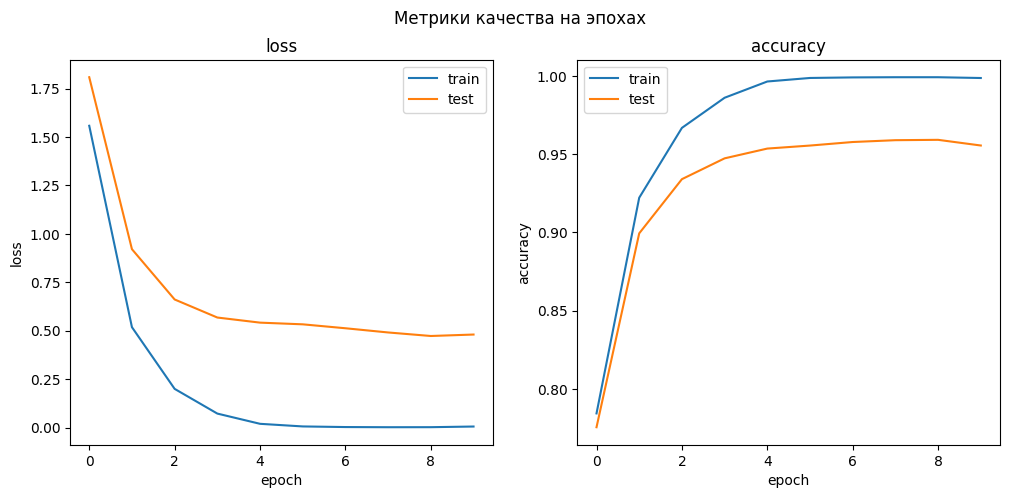

wandb: Network error (ConnectionError), entering retry loop.


In [58]:
show_metrics(lm_train_losses, lm_train_accuracies, lm_test_losses, lm_test_accuracies)

## `Реализация декодера (1 балл)`

Теперь, реализуем последнюю деталь — декодирование с использованием обученной модели.
Есть несколько вариантов. Рассмотрим два самых простых:
1. **Жадное декодирование.** На каждом шаге мы выбираем токен с максимальной вероятностью и используем его для обновления скрытого состояния RNN.
2. **Top-k sampling.** На очередном шаге рассматриваются $k$ токенов с самыми большими вероятностями. Остальные токены игнорируются. Из выбранных токенов семплируется следующий токен пропорционально их вероятностям.

Прочитать подробнее про разные варианты декодирования можно по ссылкам:
1. [От huggingface](https://huggingface.co/blog/how-to-generate)
2. [На towardsdatascience](https://towardsdatascience.com/decoding-strategies-that-you-need-to-know-for-response-generation-ba95ee0faadc)

Существенным в процессе декодирования является критерий останова. Как только очередной самый вероятный символ оказался `<eos>`, то данная последовательность считается сгенерированной. Однако, может так оказаться, что `<eos>` никогда не будет выбран, тогда необходимо прекратить генерацию, как только длина последовательности перейдёт порог `max_generated_len`.

In [63]:
@torch.no_grad()
def decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=None):
    """
    :param RNNLM model: Model
    :param torch.Tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.Tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :param int max_generated_len: Maximum lenght of generated samples
    :param Optional[int] top_k: Number of tokens with the largest probability to sample from
    :return Tuple[torch.Tensor, torch.Tensor]. 
        Newly predicted tokens and length of generated part. Shape [T*, B], [B]
    """
    # Get embedding for start_tokens
    # YOUR CODE HERE
    embedding = ...
    
    # Pass embedding through rnn and collect hidden states and cell states for each time moment
    all_h, all_c = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        # YOUR CODE HERE
        ...
    
    all_h = torch.stack(all_h, dim=1)
    all_c = torch.stack(all_c, dim=1)
    # Take final hidden state and cell state for each start sequence in batch
    # We will use them as h_0, c_0 for generation new tokens
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    
    # List of predicted tokens for each time step
    predicted_tokens = []
    # Length of generated part for each object in the batch
    decoded_lens = torch.zeros_like(start_tokens_lens, dtype=torch.long)
    # Boolean mask where we store if the sequence has already generated
    # i.e. `<eos>` was selected on any step
    is_finished_decoding = torch.zeros_like(start_tokens_lens, dtype=torch.bool)
    
    # Stop when all sequences in the batch are finished
    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        # Evaluate next token distribution using hidden state h.
        # Note. Over first dimension h has hidden states for each layer of LSTM.
        #     We must use hidden state from the last layer
        # YOUR CODE HERE
        logits = ...
        
        if top_k is not None:
            # Top-k sampling. Use only top-k most probable logits to sample next token
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            # Mask non top-k logits
            logits[indices_to_remove] = -1e10
            # Sample next_token. 
            # YOUR CODE HERE
            next_token = ...
        else:
            # Select most probable token
            # YOUR CODE HERE
            next_token = ...
            
        predicted_tokens.append(next_token)
        
        decoded_lens += (~is_finished_decoding)
        is_finished_decoding |= (next_token == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))

        # Compute embedding for next token
        # YOUR CODE HERE
        ...
        
        # Update hidden and cell states
        # YOUR CODE HERE
        ...
        
    return torch.stack(predicted_tokens), decoded_lens

Попробуем сгенерировать продолжения для нескольких префиксов:

In [64]:
start_tokens = torch.tensor([
    lm_model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    lm_model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'best', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'worst', 'movie']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [65]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=10, top_k=5)

In [66]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    
    text = ' '.join(words).replace('<', '&lt;').replace('>', '&gt;')
    display(Markdown(f'<div class="alert alert-block alert-info"> <b>{text}</b></div>'))

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; movie bad bad bad movies seen long time see one</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; favorite movie time years old man really liked movie one best films</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; best movie ever seen one best movies ever seen one best movies</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; worst movie ever seen life bad acting bad plot bad acting bad</b></div>

Попробуйте выполнить семплирование для разных $k$. Сравните результаты top-k семплирования с жадным декодированием. Опишите ваши наблюдения.

In [67]:
# YOUR CODE HERE

**Ответ:**

## `Beam Search (2 балла)`

Рассмотрим более продвинутый алгоритм для декодирования. Реализуйте алгоритм Beam Search.

Несколько замечаний по имплементации:

1. При больших размерах `beam_size` число гипотез ($B \times \text{beam\_size}$) на очередном шаге может быть слишком большим. Поэтому может потребоваться разбить все гипотезы на отдельные батчи и делать forward-pass в несколько итераций. Используйте [`torch.split`](https://pytorch.org/docs/stable/generated/torch.split.html)
2. Для выбора лучших гипотез используйте [`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html). Обратите внимание на индексы, которые возвращает эта функция (может пригодиться метод [`torch.remainder`](https://pytorch.org/docs/stable/generated/torch.remainder.html))
3. Можно отслеживать, какие элементы в батче (или какие гипотезы) закончили генерацию. Делая forward-pass только для незавершённых гипотез, можно ускорить декодинг, однако, это усложнит реализацию

In [68]:
@torch.no_grad()
def decode_beam_search(model, start_tokens, start_tokens_lens, max_generated_len=20, beam_size=5):
    """
    :param RNNLM model: Model
    :param torch.Tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.Tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :param int max_generated_len: Maximum length of generated samples
    :param int beam_size: Size of beam
    :return Tuple[torch.Tensor, torch.Tensor, torch.Tensor]. 
        Newly predicted tokens, lengths of generated parts and log probabilities for each hypotheses 
        Shape [T*, B, beam_size], [T*, beam_size], [T*, beam_size]
    """
    
    # L — number of RNN layers in the model, H — hidden size, BS — beam size
    #
    # 1. Make forward pass of start_tokens through the model. 
    #      Obtain the last cell and hidden state for each element in the batch 
    #          (i.e. tensors of shape [L, B, H])
    #      Use those states as the initialization for each hypotheses in the beam 
    #          (i.e. tensors of shape [L, B * BS, H])
    #      Initialize probabilities for each hypotheses in the beam with 1.0
    #          (i.e. tensor of shape [B * BS])
    #      Initialize vector that show whether hypothesis is finished
    #          (i.e. tensor of shape [B * BS])
    # 2. While all sequences do not end with <eos> and their length less than max_generated_len
    #      1. Get probabilities for the next token for each hypothesis 
    #          (i.e. tensor of shape [B * BS, V])
    #      2. Use those probabilities to compute probability for each extension of each hypothesis
    #          (i.e. tensor of shape [B * BS, V])
    #      3. For each element in the batch select new BS best hypotheses
    #          Note, that some of the hypotheses on the previous step have been finished
    #            so their probability should not change. So you have to select BS best hypotheses
    #            among all extension of unfinished hypotheses and finished hypotheses
    #          As a result you will have a new token for best extensions of unfinished hypotheses
    #          For simplisity you can use <EOS> token if you select finished hypothesis in the beam
    #            i.e. tensor of shape [B * BS] of indices for selected hypotheses and
    #                 tensor of shape [B * BS] of extension tokens for each hypothesis
    #      4. Update probabilities for each hypotheses and is_finished state for each hypothesis
    #          Concat new tokens to the existing prefixes
    #      5. Update hidden and cell state to correspond to the selected hypothesis

    eos_idx = model.vocab.get_stoi()['<eos>']
    
    # Get embeddings for the start tokens
    # YOUR CODE HERE
    ...
    
    # Make forward pass through the RNN and 
    #   obtain the last cell and hidden state for each element in the batch
    # YOUR CODE HERE
    ...

    start_h = ... # [L, B, H]
    start_c = ... # [L, B, H]

    # Use those states as the initialization for each hypotheses in the beam
    # YOUR CODE HERE
    ...
    h = ... # [L, B * BS, H]
    c = ... # [L, B * BS, H]
    
    # Select initial tokens for each hypotheses in the beam
    #   Compute log probabilities and select top-beam_size tokens for each element
    #   Use them to initialize beam search state
    # YOUR CODE HERE
    ...
    
    new_tokens = ... # [B * BS]
    log_probas = ... # [B * BS]
    hypotesis = ... # [1, B * BS]
    
    is_finished = ... # [B * BS]
    decoded_lens = ... # [B * BS]

    while not torch.all(is_finished) and hypotesis.shape[0] < max_generated_len:
        # Get probabilities for the next token for each hypothesis
        # YOUR CODE HERE
        ...

        next_token_log_probas = ... # [B * BS, V]
        
        # Use those probabilities to compute probability for each extension of each hypothesis
        # YOUR CODE HERE
        ...
        extension_log_probas = ... # [B * BS, V]

        # For each element in the batch select new BS best hypotheses
        #   You can use loop over different beams
        # YOUR CODE HERE
        ...

        # Update probabilities for each hypotheses and is_finished state and decoded_lens for each hypothesis
        # YOUR CODE HERE
        ...

        # Concat new tokens to the existing prefixes
        # YOUR CODE HERE
        ...
        
        # Update hidden and cell state to correspond to the selected hypothesis
        # YOUR CODE HERE
        ...
        
    return (
        hypotesis.view(-1, start_tokens.shape[1], beam_size), 
        decoded_lens.view(start_tokens.shape[1], beam_size),
        log_probas.view(start_tokens.shape[1], beam_size)
    )

In [69]:
start_tokens = torch.tensor([
    lm_model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    lm_model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'best', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'worst', 'movie']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [70]:
lm_model.to(device).eval()
start_tokens = start_tokens.to(device)
start_tokens_lens = start_tokens_lens.to(device)

In [71]:
beam_size = 100
decoded_tokens, decoded_lens, log_probas = decode_beam_search(
    lm_model, start_tokens, start_tokens_lens, max_generated_len=10, beam_size=beam_size
)

In [72]:
for start_tokens_elem, start_tokens_lens_elem, decoded_tokens_elem, decoded_lens_elem, log_probas_elem in zip(
    start_tokens.T, start_tokens_lens,
    decoded_tokens.permute(1, 2, 0), decoded_lens.permute(0, 1), log_probas.permute(0, 1)
):
    start_tokens_elem = start_tokens_elem[:start_tokens_lens_elem].tolist()
    start_words = np.array(lm_model.vocab.get_itos())[np.array(start_tokens_elem)]
    
    start_text = ' '.join(start_words).replace('<', '&lt;').replace('>', '&gt;')
    display(Markdown(f'<div class="alert alert-block alert-info"> <b>{start_text}</b></div>'))
    
    for idx, (hyp, hyp_len, hyp_log_prob) in enumerate(zip(decoded_tokens_elem, decoded_lens_elem, log_probas_elem)):
        if idx >= 3:
            break
            
        hyp = hyp[:hyp_len].tolist()
        hyp_words = np.array(lm_model.vocab.get_itos())[np.array(hyp)]
        hyp_text = ' '.join(hyp_words).replace('<', '&lt;').replace('>', '&gt;')
        display(Markdown(
            f'<div class="alert alert-block alert-success"> <b>{hyp_log_prob:.3f}: {hyp_text}</b></div>'
        ))

<div class="alert alert-block alert-info"> <b>&lt;sos&gt;</b></div>

<div class="alert alert-block alert-success"> <b>-14.700: one worst movies ever seen one worst movies ever seen</b></div>

<div class="alert alert-block alert-success"> <b>-15.791: one worst movies ever seen bad acting bad acting bad</b></div>

<div class="alert alert-block alert-success"> <b>-16.008: one worst movies ever seen one worst movies ever made</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; favorite movie</b></div>

<div class="alert alert-block alert-success"> <b>-16.961: one worst movies ever seen one worst movies ever seen</b></div>

<div class="alert alert-block alert-success"> <b>-17.999: ever seen one worst movies ever seen bad acting bad</b></div>

<div class="alert alert-block alert-success"> <b>-18.038: one worst movies ever seen one worst movies ever made</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; best movie</b></div>

<div class="alert alert-block alert-success"> <b>-15.690: ever seen one worst movies ever seen bad acting bad</b></div>

<div class="alert alert-block alert-success"> <b>-16.193: ever seen one worst movies ever seen long time life</b></div>

<div class="alert alert-block alert-success"> <b>-16.346: ever seen one one worst movies ever seen long time</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; worst movie</b></div>

<div class="alert alert-block alert-success"> <b>-14.730: ever seen one worst movies ever seen bad acting bad</b></div>

<div class="alert alert-block alert-success"> <b>-14.844: ever seen bad acting bad acting bad bad acting bad</b></div>

<div class="alert alert-block alert-success"> <b>-14.857: ever seen life one worst movies ever seen long time</b></div>

Попробуйте выполнить декодинг для разных `beam_size`. Убедитесь, что при `beam_search=1` семплирование совпадает с top-1 (greedy decoding) подходом. 

Сравните результаты Beam Search с top-k семплированием и жадным декодированием. Опишите ваши наблюдения.

In [ ]:
# YOUR CODE HERE

## `Бонус. Существенное улучшение качества (до 6 баллов)`

Та модель, которая использовалась в предыдущей части во многом заимствует улучшения LSTM из статьи [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/pdf/1708.02182.pdf). Вы можете попробовать применить другие варианты регуляризации из данной статьи для существенного улучшения качества LM.

Например:
1. Dropout для эмбеддингов **(+0.25)**
2. Dropout входов и выходов RNN **(+0.25)**
3. Регуляризация активаций (AR/TAR) **(+1.0)**
4. NT-ASGD **(+1.5)**
5. Tied веса эмбеддингов и софтмакса **(+1.0)**
6. Attention **(+2.0)**

**Полные баллы ставятся только при наличии качественного и количественного сравнения с бейзлайном.**

**Для эксперимента с Attention необходимо изобразить Attention Maps для нескольких примеров.**